In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt

import os
import logging

import numpy as np
import numpy.ma as ma

import pickle
from pathlib import Path

from IPython.display import clear_output
import gc

logger = logging.getLogger(__name__)


In [16]:
def get_jules_scenarios():
    """
        Return a List containing SCENARIO tag names
    """
    LU_SCENARIOS = [ 'nolucbio','nolucaff','nattobio','nattoaff','agtonat','agtobio','agtoaff' ]
    CLIM_SCENARIOS = [ 'ssp126', 'ssp370' ]
    CLIM_MODELS = [ 'mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr' ]
    return LU_SCENARIOS, CLIM_SCENARIOS, CLIM_MODELS

In [2]:
def add_metadata(cube, field, fname):
    
    esm_id = fname.split('_')[1]
    ssp_id = fname.split('_')[2]

    iris.std_names.STD_NAMES['experiment_id'] = {'canonical units':'1'}
    
    #if not cube.coords("experiment_id"):
    climate_coord = iris.coords.AuxCoord(ssp_id, "experiment_id", units="1", long_name="experiment_id")
    cube.add_aux_coord(climate_coord)

    #if not cube.coords("realization"):
    esm_coord = iris.coords.AuxCoord(esm_id, "realization", units="1")
    cube.add_aux_coord(esm_coord)

    pft_dim = iris.coords



In [3]:
def _get_land_fraction(cube,area_type):
    """Extract land fraction as :mod:`dask.array`."""
    fx_cube = None
    land_fraction = None
    errors = []
    
    try:
        if area_type == 'land':
            fx_cube = cube.ancillary_variable('land_area_fraction')
        elif area_type == 'ice': 
            fx_cube = cube.ancillary_variable('ice_fraction')
    except iris.exceptions.AncillaryVariableNotFoundError:
        errors.append('Ancillary variables land/sea/ice area fraction not '
                              'found in cube. Check ancillary data availability.')
        return (land_fraction, errors)

    land_fraction = fx_cube.core_data()
    
    if fx_cube.var_name == 'sftlf':
        land_fraction = fx_cube.core_data() / 100.0
    if fx_cube.var_name == 'sftof':
        land_fraction = 1.0 - fx_cube.core_data() / 100.0
    
    return (land_fraction, errors)

In [4]:
def weighting_landsea_fraction(cube, area_type):
    """Weight fields using land or sea fraction.

    This preprocessor function weights a field with its corresponding land or
    sea area fraction (value between 0 and 1). The application of this is
    important for most carbon cycle variables (and other land-surface outputs),
    which are e.g. reported in units of `kgC m-2`. This actually refers to 'per
    square meter of land/sea' and NOT 'per square meter of gridbox'. So in
    order to integrate these globally or regionally one has to both area-weight
    the quantity but also weight by the land/sea fraction.

    Parameters
    ----------
    cube : iris.cube.Cube
        Data cube to be weighted. It should have an
        :class:`iris.coords.AncillaryVariable` with standard name
        ``'land_area_fraction'`` or ``'sea_area_fraction'``. If both are
        present, only the ``'land_area_fraction'`` will be used.
    area_type : str
        Use land (``'land'``) or sea (``'sea'``) fraction for weighting.

    Returns
    -------
    iris.cube.Cube
        Land/sea fraction weighted cube.

    Raises
    ------
    TypeError
        ``area_type`` is not ``'land'`` or ``'sea'``.
    ValueError
        Land/sea fraction variables ``sftlf`` or ``sftof`` not found.
    """
    if area_type not in ('land', 'sea', 'ice'):
        raise TypeError(
            f"Expected 'land' or 'sea' or 'ice' for area_type, got '{area_type}'")
    (land_fraction, errors) = _get_land_fraction(cube,area_type)
    if land_fraction is None:
        raise ValueError(
            f"Weighting of '{cube.var_name}' with '{area_type}' fraction "
            f"failed because of the following errors: {' '.join(errors)}")

    core_data = cube.core_data()
    if area_type == 'land':
        cube.data = core_data * land_fraction
    elif area_type == 'sea':
        cube.data = core_data * (1.0 - land_fraction)
    elif area_type == 'ice':
        cube.data = core_data * (1.0 - land_fraction) # Ice will be 0 or 1
    return cube

In [5]:
def add_latlon(cube,field,fname):

    latitudes = iris.load('/home/aharper/mask_latlon2d.nc','lat')
    longitudes = iris.load('/home/aharper/mask_latlon2d.nc','lon')
    latcoord2 = iris.coords.DimCoord(latitudes,"latitude")
    loncoord2 = iris.coords.DimCoord(longitudes,"longitude")
    cube.add_dim_coord(latcoord2, 0)
    cube.add_dim_coord(loncoord2, 1)   

In [6]:
def add_ancillary_variable(cube, temp_ancil_cube):
    """Add cube as an ancillary variable in the cube containing the data.

    Parameters
    ----------
    cube: iris.cube.Cube
        Iris cube with input data.
    temp_ancil_cube: iris.cube.Cube
        Iris cube with ancillary data.

    Returns
    -------
    iris.cube.Cube
        Cube with added ancillary variables
    """
    
    cube_left_lat = cube.coord("longitude").points[0]
    cube_right_lat = cube.coord("longitude").points[-1]

    acube_left_lat = temp_ancil_cube.coord("longitude").points[0]
    acube_right_lat = temp_ancil_cube.coord("longitude").points[-1]

    if cube_left_lat != acube_left_lat:
        ancillary_cube = temp_ancil_cube.intersection(longitude=(-180,180), ignore_bounds=True )
    else:
        ancillary_cube = temp_ancil_cube
        
    ancillary_var = iris.coords.AncillaryVariable(
        ancillary_cube.core_data(),
        standard_name=ancillary_cube.standard_name,
        units=ancillary_cube.units,
        var_name=ancillary_cube.var_name,
        attributes=ancillary_cube.attributes)
    start_dim = cube.ndim - len(ancillary_var.shape)
    cube.add_ancillary_variable(ancillary_var, range(start_dim, cube.ndim))
    logger.debug('Added %s as ancillary variable in cube of %s.',
                 ancillary_cube.var_name, cube.var_name)

In [7]:
def retrieve_data(var,LU_SCENARIO):

    landuse, ssp, esm = get_jules_scenarios()

    path = ''

    nclim = len(esm)
    years = np.arange(2015,2101)
    
    
    # I need to read in land fraction file for JULES
    land_frac = iris.load_cube('/home/aharper/mask_latlon2d.nc','land_sea_mask')
    land_frac.standard_name='land_area_fraction'

    filenames = ['/bdd/ESM2025/WP10/jules/jules_mpi-esm1-2-hr_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ipsl-cm6a-lr_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_mpi-esm1-2-hr_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ipsl-cm6a-lr_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc']    


    my_file = Path('/bdd/ESM2025/WP10/analysis/files/jules_'+var+'_'+LU_SCENARIO+'.pkl')
    firstmap_file = Path('/bdd/ESM2025/WP10/analysis/files/jules_'+var+'_'+LU_SCENARIO+'_2015.pkl')
    lastmap_file = Path('/bdd/ESM2025/WP10/analysis/files/jules_'+var+'_'+LU_SCENARIO+'_2100.pkl')    
    print(my_file)

    if firstmap_file.is_file():
        # file exists, we can skip a bunch of steps:
        with open(my_file, 'rb') as f:
            ENSEMBLE_MEAN = pickle.load(f)
  
    else:
        # file doesn't exist, loop through scenarios and get data
        # or we want to make a map
        esms = iris.load(filenames, callback=add_metadata)

        ENSEMBLE_MEAN = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        FIRST_TIMESTEP = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        LAST_TIMESTEP = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        
        for ssp_id in ssp:
        
            for esm_id in esm:
                esm_cube = esms.extract_cube(iris.Constraint(realization=esm_id,experiment_id=ssp_id) )
            
                add_ancillary_variable(esm_cube,land_frac)
        
                #esm_cube.coords.AncillaryVariable(land_frac, standard_name='land_area_fraction')
        
                latcoord = esm_cube.coord("latitude")
                latcoord.units="degrees"
                loncoord = esm_cube.coord("longitude")
                loncoord.units="degrees"        
        
                tcoord = esm_cube.coord("time")
                tcoord.units="seconds since 2015-01-01 0:0:0"
                tcoord.calendar="calendar_no_leap"

                firstdate = tcoord.units.num2date(tcoord.points[0])
                iris.coord_categorisation.add_year(esm_cube,'time',name='year')        

                weighting_landsea_fraction(esm_cube, 'land')
        
                #Calculates the annual mean from monthly values.
                cveg_annual_map = esm_cube.aggregated_by('year',iris.analysis.MEAN)
                   
                cveg_annual_map.coord("latitude").guess_bounds()
                cveg_annual_map.coord("longitude").guess_bounds() 

                # Plot #1: contourf of first time step
                plt.figure(figsize=(12, 5))
                plt.subplot(121)
                qplt.contourf(cveg_annual_map[0,], 15)
                plt.gca().coastlines()
                plt.title(esm_id+" 2015")

                # Plot #2: contourf of last time step
                plt.subplot(122)
                qplt.contourf(cveg_annual_map[-1,], 15)
                plt.gca().coastlines()
                plt.title(esm_id+" 2100")
                qplt.show()

                FIRST_TIMESTEP[ssp_id][esm_id].append(cveg_annual_map[0,].core_data())
                LAST_TIMESTEP[ssp_id][esm_id].append(cveg_annual_map[-1,].core_data())
                
                #Next calculate the global total
       
                grid_areas = iris.analysis.cartography.area_weights(cveg_annual_map)
                print(cveg_annual_map)
                cveg_global = (cveg_annual_map.collapsed(["latitude","longitude"], iris.analysis.SUM, weights=grid_areas)/1.0e12)

                #The data is lazy we need to make it real:
                cveg_global.data
                #print(cveg_global.core_data())
        
                #Calculate the mean across the 3 climate models for each SSP scenario.
                #ensemble_mean = cveg_global.collapsed("realization",iris.analysis.MEAN)
                ENSEMBLE_MEAN[ssp_id][esm_id].append(cveg_global.core_data())
   
                #iplt.plot(cveg_global, label=esm_id, lw=1.5, color="blue")
                #plt.legend(loc="upper left")
                #plt.title("No LUC", fontsize=18)

                #plt.xlabel("year")
                #plt.ylabel("Cveg PgC")
                #plt.grid() 

        
        with open(my_file, 'wb') as f:
            pickle.dump(ENSEMBLE_MEAN, f)          
        with open(firstmap_file, 'wb') as f2:
            pickle.dump(FIRST_TIMESTEP, f2)
        with open(lastmap_file, 'wb') as f3:
            pickle.dump(LAST_TIMESTEP, f3)
            
    return ENSEMBLE_MEAN
    

In [8]:
def retrieve_data_v2(var,LU_SCENARIO, ice):

    landuse, ssp, esm = get_jules_scenarios()

    path = ''

    nclim = len(esm)
    years = np.arange(2015,2101)
    
    
    # I need to read in land fraction file for JULES
    land_frac = iris.load_cube('/home/aharper/mask_latlon2d.nc','land_sea_mask')
    land_frac.standard_name='land_area_fraction'

    ice.standard_name='ice_fraction'

    filenames = ['/bdd/ESM2025/WP10/jules/jules_mpi-esm1-2-hr_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ipsl-cm6a-lr_ssp126_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_mpi-esm1-2-hr_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                 '/bdd/ESM2025/WP10/jules/jules_ipsl-cm6a-lr_ssp370_'+LU_SCENARIO+'_'+var+'.monthly.nc']    


    my_file = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_'+LU_SCENARIO+'.pkl')
    firstmap_file = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_'+LU_SCENARIO+'_2015.pkl')
    lastmap_file = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_'+LU_SCENARIO+'_2100.pkl')    
    print(my_file)

    if firstmap_file.is_file():
        # file exists, we can skip a bunch of steps:
        with open(my_file, 'rb') as f:
            ENSEMBLE_MEAN = pickle.load(f)
  
    else:
        # file doesn't exist, loop through scenarios and get data
        # or we want to make a map
        esms = iris.load(filenames, callback=add_metadata)

        ENSEMBLE_MEAN = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        FIRST_TIMESTEP = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        LAST_TIMESTEP = {ssp_scen: {clim_mod: [] for clim_mod in esm} for ssp_scen in ssp}
        
        for ssp_id in ssp:
        
            for esm_id in esm:
                esm_cube = esms.extract_cube(iris.Constraint(realization=esm_id,experiment_id=ssp_id) )
            
                add_ancillary_variable(esm_cube,land_frac)
        
                #esm_cube.coords.AncillaryVariable(land_frac, standard_name='land_area_fraction')
        
                latcoord = esm_cube.coord("latitude")
                latcoord.units="degrees"
                loncoord = esm_cube.coord("longitude")
                loncoord.units="degrees"        
        
                tcoord = esm_cube.coord("time")
                tcoord.units="seconds since 2015-01-01 0:0:0"
                tcoord.calendar="calendar_no_leap"

                firstdate = tcoord.units.num2date(tcoord.points[0])
                iris.coord_categorisation.add_year(esm_cube,'time',name='year')        

                ice_cube = iris.cube.Cube(ice,dim_coords_and_dims=[(latcoord, 0), (loncoord, 1)],long_name=
                                         'ice_fraction', var_name='ice_fraction')
                
                add_ancillary_variable(esm_cube,ice_cube)
                
                weighting_landsea_fraction(esm_cube, 'land')
#                print("example points:")
#                print(esm_cube[0,78,60:75].data)
#                print(ice_cube[78,60:75].data)
#                print(latcoord[78])
#                print(loncoord[60:75])
                weighting_landsea_fraction(esm_cube, 'ice' )
#                print(esm_cube[0,78,60:75].data)
        
                #Calculates the annual mean from monthly values.
                cveg_annual_map = esm_cube.aggregated_by('year',iris.analysis.MEAN)
                   
                cveg_annual_map.coord("latitude").guess_bounds()
                cveg_annual_map.coord("longitude").guess_bounds() 

                # Plot #1: contourf of first time step
                plt.figure(figsize=(12, 5))
                plt.subplot(131)
                qplt.contourf(cveg_annual_map[0,], 15)
                plt.gca().coastlines()
                plt.title(esm_id+" 2015")

                # Plot #2: contourf of last time step
                plt.subplot(132)
                qplt.contourf(cveg_annual_map[-1,], 15)
                plt.gca().coastlines()
                plt.title(esm_id+" 2100")
                
                # Plot #3: contourf of diff
                plt.subplot(133)
                diff=cveg_annual_map[-1,]-cveg_annual_map[-0,]
                qplt.contourf(diff, 15)
                plt.gca().coastlines()
                plt.title(LU_SCENARIO+ssp_id+esm_id+" DIFF")
                qplt.show()

                FIRST_TIMESTEP[ssp_id][esm_id].append(cveg_annual_map[0,].core_data())
                LAST_TIMESTEP[ssp_id][esm_id].append(cveg_annual_map[-1,].core_data())
                
                #Next calculate the global total
       
                grid_areas = iris.analysis.cartography.area_weights(cveg_annual_map)
                
                cveg_global = (cveg_annual_map.collapsed(["latitude","longitude"], iris.analysis.SUM, weights=grid_areas)/1.0e12)
                
                global_diff = (diff.collapsed(["latitude","longitude"], iris.analysis.SUM, weights=grid_areas[0,])/1.0e12)
                print(ssp_id,esm_id,LU_SCENARIO,var,global_diff.data)
                
                #The data is lazy we need to make it real:
                cveg_global.data
                #print(cveg_global.core_data())
        
                #Calculate the mean across the 3 climate models for each SSP scenario.
                #ensemble_mean = cveg_global.collapsed("realization",iris.analysis.MEAN)
                ENSEMBLE_MEAN[ssp_id][esm_id].append(cveg_global.core_data())
   
                #iplt.plot(cveg_global, label=esm_id, lw=1.5, color="blue")
                #plt.legend(loc="upper left")
                #plt.title("No LUC", fontsize=18)

                #plt.xlabel("year")
                #plt.ylabel("Cveg PgC")
                #plt.grid() 

                del cveg_annual_map
                del cveg_global
        
        with open(my_file, 'wb') as f:
            pickle.dump(ENSEMBLE_MEAN, f)          
        with open(firstmap_file, 'wb') as f2:
            pickle.dump(FIRST_TIMESTEP, f2)
        with open(lastmap_file, 'wb') as f3:
            pickle.dump(LAST_TIMESTEP, f3)
            
    return ENSEMBLE_MEAN
    

In [17]:
def get_ice_points(var):
    ssp = 'ssp126'
    esm = 'ukesm1-0-ll'
    path = '' 

    ncfile2=Dataset('/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp126_nolucbio_landCoverFrac.monthly.nc', 'r')
    ice_points1 = ncfile2.variables['landCoverFrac'][0,17,:,:]

    
    ncfile3=Dataset('/bdd/ESM2025/WP10/jules/jules_ukesm1-0-ll_ssp126_nolucaff_landCoverFrac.monthly.nc', 'r')
    ice_points2 = ncfile3.variables['landCoverFrac'][0,25,:,:]
    ma.masked_where(ice_points1<1.0,ice_points1) 
    
#    fig, axs = plt.subplots(nrows=1,ncols=2,
#                        subplot_kw={'projection': ccrs.PlateCarree()},
#                        figsize=(11,8.5))

#    axs=axs.flatten()
    
#    print(ice_points1.shape,lons.shape,lats.shape)
#    clevs=np.arange(0,1,0.1)
#    cs=axs[0].contourf(ice_points1, clev=clevs,
#                      transform = ccrs.PlateCarree(),
#                      cmap='BrBG',extend='both')              
#    axs[0].set_title('From nolucbio')
#    axs[0].coastlines()
#
#    cs=axs[1].contourf(ice_points2, clev=clevs,
#                      transform = ccrs.PlateCarree(),
#                      cmap='BrBG',extend='both')              
#    axs[1].set_title('From nolucaff')
#    axs[1].coastlines()
    
    # Adjust the location of the subplots on the page to make room for the colorbar
#    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
#                        wspace=0.02, hspace=0.04)

    # Add a colorbar axis at the bottom of the graph
#    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

    # Draw the colorbar
#    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
    
#    plt.show()

    return ice_points1

In [10]:
def retrieve_fracs(LU_SCENARIO,aggregate_pfts,ssp,esm):
    
    var = 'landCoverFrac'
    #ssp = 'ssp126'
    #esm = 'ukesm1-0-ll'
    path = '' 
    
    nclim = len(esm)
    years = np.arange(2015,2101)


    ncfile1 = Dataset('/home/aharper/mask_latlon2d.nc', 'r')
    lons = ncfile1.variables['lon']
    lats = ncfile1.variables['lat']
    land_fraction = ncfile1.variables['land_sea_mask']

    ncfile2=Dataset('/bdd/ESM2025/WP10/jules/jules_'+esm+'_'+ssp+'_'+LU_SCENARIO+\
            '_landCoverFrac.monthly.nc', 'r')
       
    if LU_SCENARIO == 'nolucbio' or LU_SCENARIO == 'nattobio' or LU_SCENARIO == 'agtobio':
        npft = 14
        pfts = ['BET-Tr', 'BET-Te', 'BDT', 'NET', 
                'NDT','C3G(nat)', 'C3G(crop)', 'C3G(past)', 
                'C4G(nat)','C4G(crop)', 'C4G(past)', 'ESh', 
                'DSh', 'Misc(bio)']
        grouped_pfts = ['All Trees','All Grasses','Food crops','All Shrubs','BE Crops']
        grouped_indx = [0,0,0,0,0,1,2,2,1,2,2,3,3,4]
    else:
        npft = 22
        pfts = ['BET-Tr', 'BET-Te', 'BDT', 'NET', 
                'NDT','C3G(nat)', 'C3G(crop)', 'C3G(past)', 
                'C4G(nat)','C4G(crop)', 'C4G(past)', 'ESh', 
                'DSh', 'BET-Tr(bio)', 'BET-Te(bio)', 'BDT(bio)', 
                'NET(bio)', 'NDT(bio)','C3G(bio)', 'C4G(bio)',
                'ESh(bio)', 'DSh(bio)']
        grouped_pfts = ['All Trees','All Grasses','Food crops','All Shrubs']
        grouped_indx = [0,0,0,0,0,1,2,2,1,2,2,3,3,0,0,0,0,0,1,1,3,3]
        
    ntime = 86
    nlon = 180
    nlat = 90
    
    ngroups = len(grouped_pfts)
    
    iplt=0
    ipg=0
    if aggregate_pfts==True:
        global_frac = np.empty([86,ngroups+1])
        frac_2100 = np.empty([ngroups+1,nlat,nlon])
    else:
        global_frac = np.empty([86,npft+1])
        frac_2100 = np.empty([npft+1,nlat,nlon])

    fracs = ncfile2.variables['landCoverFrac'][::12,0,:,:]
    weights = np.empty_like(fracs)
    for kk in range(nlat):
        weights[:,kk,:] = np.cos(np.deg2rad(lats[kk]))    
    del fracs
    
    for ij in range(npft):
        if iplt==0 and aggregate_pfts==False:
            fig,axes=plt.subplots(4, figsize=[8,11])      
        fracs = ncfile2.variables['landCoverFrac'][::12,ij,:,:]

        if aggregate_pfts==True:
            ipft = grouped_indx[ij]
            global_frac[:,ipft] = global_frac[:,ipft] + np.mean(fracs * weights, axis=(1,2))
            frac_2100[ipft,:,:] = fracs[-1,:,:]
        else:
            global_frac[:,ij] = np.mean(fracs * weights, axis=(1,2))
            frac_2100[ij,:,:] = fracs[-1,:,:]
        
        del fracs
        
        if aggregate_pfts==False:
            ax=axes[iplt]
            ax.set_ylabel('Frac (--)',fontsize=10)
            ax.set_xlim([2015,2100])
            #ax.set_ylim([0.0,0.2])
            ax.set_title(pfts[ij])
            ax.grid(True) 
        
            ax.plot(years, global_frac[:,ij], lw=2)  
            iplt+=1
            if iplt==4:
                iplt = 0
                ipg+=1
                plt.savefig('/bdd/ESM2025/WP10/plots/jules/jules_fracs_'\
                            +LU_SCENARIO+'_pg'+str(ipg)+'.png', format="png")

    
    if aggregate_pfts==True:
        iplt = 0
        ipg=0
        fig,axes=plt.subplots(6,figsize=[8,11])
        for ij in range(ngroups):
            ax=axes[iplt]
            ax.set_ylabel('Frac (--)', fontsize=10)
            ax.set_xlim([2015,2100])
            ax.set_title(grouped_pfts[ij])
            ax.grid(True)
            ax.plot(years,global_frac[:,ij], lw=2)
            iplt+=1
            if iplt==4:
                ipg+=1
                plt.savefig('/bdd/ESM2025/WP10/plots/jules/jules_aggfracs_'\
                             +LU_SCENARIO+'_pg'+str(ipg)+'.png', format="png", dpi=400)
                
    #BARE SOIL
    ax=axes[iplt]
    ax.set_ylabel('Frac (--)',fontsize=10)
    ax.set_xlim([2015,2100])
    #ax.set_ylim([0.0,0.1])
    ax.set_title("Bare Soil")
    ax.grid(True) 
    
    fracs = ncfile2.variables['landCoverFrac'][::12,npft+2,:,:]
    if aggregate_pfts==True:
        global_frac[:,ngroups] = np.mean(fracs * weights, axis=(1,2))
        ax.plot(years, global_frac[:,ngroups], lw=2)  
        ipg+=1
        #fig.delaxes(axes[3])  
        plt.savefig('/bdd/ESM2025/WP10/plots/jules/jules_aggfracs_'\
                    +LU_SCENARIO+'_pg'+str(ipg)+'.png', format="png", dpi=400)          
    else:
        global_frac[:,npft] = np.mean(fracs * weights, axis=(1,2))
        ax.plot(years, global_frac[:,npft], lw=2)
        ipg+=1
        fig.delaxes(axes[3])  
        plt.savefig('/bdd/ESM2025/WP10/plots/jules/jules_fracs_'\
                    +LU_SCENARIO+'_pg'+str(ipg)+'.png', format="png", dpi=400)          
    del fracs

     
    plt.close()    
    del fig
    del axes 
    
    return global_frac,frac_2100
    

In [11]:
def map_diff(var,ssp,esm,SCENARIO_TITLES,PLOT_TITLES):
    """Map the difference between the scenario and no LUC, in terms of
    delta-C (= 2100-2015).

    Parameters
    ----------
    var: Which variable will be mapped. Valid choices are 'cSoil' or 'cVeg'
    
    scenario_title: Name of the land use scenario
    
    plot_title: Longer string for the title of the map

    Returns
    -------
    Nothing: But makes the png files
    """

    firstmap_biofile = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_nolucbio_2015.pkl')
    lastmap_biofile = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_nolucbio_2100.pkl')
    firstmap_afffile = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_nolucaff_2015.pkl')
    lastmap_afffile = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_nolucaff_2100.pkl')
    
    with open(firstmap_biofile, 'rb') as f:
        NOLUCBIO_START = pickle.load(f)
    with open(lastmap_biofile, 'rb') as f2:
        NOLUCBIO_END = pickle.load(f2)
    with open(firstmap_afffile, 'rb') as f3:
        NOLUCAFF_START = pickle.load(f3)
    with open(lastmap_afffile, 'rb') as f4:
        NOLUCAFF_END = pickle.load(f4)
        
    file2read = Dataset("mask_latlon2d.nc", "r")
    templon = file2read.variables['lon']
    templat = file2read.variables['lat']
    land_fraction = file2read.variables['land_sea_mask']
    
    lats = templat[:]*1
    lons = templon[:]*1
#    lons = np.empty_like(templon)
#    lons[90:180] = templon[0:90]*1  
#    lons[0:90] = templon[90:180]*1  
    
    nclim = len(esm)

    #https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html
    fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)},
                        figsize=(11,8.5))
    
    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    
    if var=='cSoil':
        clevs=np.arange(-3,4,1)
    else: 
        clevs=np.arange(-5,6,1)
    i=0
    for i1 in range(0,2):
        for i0 in range(0,nclim): 

            darray1 = np.array(NOLUCBIO_END[ssp[i1]][esm[i0]])
            darray2 = np.array(NOLUCBIO_START[ssp[i1]][esm[i0]])
            mapdata = darray1 - darray2

            #mapdata = mapdata * land_fraction
            ma.masked_values(mapdata,0.0,rtol=0.01)
                             
            cs=axs[i].contourf(lons,lats,mapdata[0,], clevs,
                      transform = ccrs.PlateCarree(central_longitude=180.0),
                      cmap='BrBG',extend='both')              
            axs[i].set_title(esm[i0]+", "+ssp[i1])
            axs[i].coastlines()

            i+=1
            
    # Delete the unwanted axes
    #for i in [6,7]:
    #    fig.delaxes(axs[i])    

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                        wspace=0.02, hspace=0.04)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

    # Add a big title at the top
    plt.suptitle('No LUC BIO')     
    plt.savefig('/bdd/ESM2025/WP10/maps/jules/jules_nolucbio_'+var+'.png', 
                                    format="png", dpi=400)
    del mapdata
    del darray1
    del darray2
    
    i=0   
    # PLOT NO LUC AFF 
    for i1 in range(0,2):
        for i0 in range(0,nclim): 

            darray1 = np.array(NOLUCAFF_END[ssp[i1]][esm[i0]])
            darray2 = np.array(NOLUCAFF_START[ssp[i1]][esm[i0]])
            mapdata = darray1 - darray2

            #mapdata = mapdata * land_fraction
            ma.masked_values(mapdata,0.0,rtol=0.01)        
            cs=axs[i].contourf(lons,lats,mapdata[0,], clevs,
                      transform = ccrs.PlateCarree(central_longitude=180.0),
                      cmap='BrBG',extend='both')              
            axs[i].set_title(esm[i0]+", "+ssp[i1])
            axs[i].coastlines()

            i+=1

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                        wspace=0.02, hspace=0.04)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

    # Add a big title at the top
    plt.suptitle('No LUC AFF')     
    plt.savefig('/bdd/ESM2025/WP10/maps/jules/jules_nolucaff_'+var+'.png', 
                                    format="png", dpi=400)    
    del mapdata
    del darray1
    del darray2
    
    # Next plot the scenario differences.
    for i2 in range(0,5):
        scenario_title = SCENARIO_TITLES[i2]
        plot_title = PLOT_TITLES[i2]
        
        scenario_file1 = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_'+scenario_title+'_2015.pkl')
        scenario_file2 = Path('/bdd/ESM2025/WP10/analysis/files2/jules_'+var+'_'+scenario_title+'_2100.pkl')

        with open(scenario_file1, 'rb') as f5:
            SCENARIO_START = pickle.load(f5)
        with open(scenario_file2, 'rb') as f6:
            SCENARIO_END = pickle.load(f6)

        fig2, axs2 = plt.subplots(nrows=2,ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)},
                            figsize=(11,8.5))
    
        # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
        axs2=axs2.flatten()
    
        if var=='cSoil':
            clevs2=np.arange(-1,1.25,0.25)
        else: 
            clevs2=np.arange(-1,1.25,0.25)
 
        i=0
        for i1 in range(0,2):
            for i0 in range(0,nclim): 

                if scenario_title == 'nattobio' or scenario_title == 'agtobio':
                    darray1 = np.array(NOLUCBIO_END[ssp[i1]][esm[i0]])
                    darray2 = np.array(NOLUCBIO_START[ssp[i1]][esm[i0]])
                else:
                    darray1 = np.array(NOLUCAFF_END[ssp[i1]][esm[i0]])
                    darray2 = np.array(NOLUCAFF_START[ssp[i1]][esm[i0]])

                darray3 = np.array(SCENARIO_END[ssp[i1]][esm[i0]])
                darray4 = np.array(SCENARIO_START[ssp[i1]][esm[i0]])
                mapdata_scenario = (darray3 - darray4) - (darray1 - darray2)
                mapdata_scenario = mapdata_scenario * land_fraction
                ma.masked_values(mapdata_scenario,0.0,rtol=0.01)
                cs=axs2[i].contourf(lons,lats,mapdata_scenario[0,], clevs2,
                          transform = ccrs.PlateCarree(central_longitude=180.0),
                          cmap='BrBG',extend='both')              
                axs2[i].set_title(esm[i0]+", "+ssp[i1])
                axs2[i].coastlines()

                i+=1

            
        # Delete the unwanted axes
        #for i in [6,7]:
        #    fig.delaxes(axs[i])    

        # Adjust the location of the subplots on the page to make room for the colorbar
        fig2.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                            wspace=0.02, hspace=0.04)

        # Add a colorbar axis at the bottom of the graph
        cbar_ax2 = fig2.add_axes([0.2, 0.2, 0.6, 0.02])

        # Draw the colorbar
        cbar=fig2.colorbar(cs, cax=cbar_ax2,orientation='horizontal')

        # Add a big title at the top
        plt.suptitle(plot_title)     
        plt.savefig('/bdd/ESM2025/WP10/maps/jules/jules_'+scenario_title+'_'+var+'diff.png', 
                                    format="png", dpi=400)

In [12]:
def plot_jules_ts_pft(plot_dict,varname):
    # Input must be a dictionary of [scenario][ssp][esm] with each entry having 86 years.
    SCENARIO_TITLES, SSPS, ESMS = get_jules_scenarios()
    nscenarios = len(SCENARIO_TITLES)
    nssp = len(SSPS)
    nesm = len(ESMS)
    
    years = np.arange(2015,2101)     

    fig,axes=plt.subplots(3,1, figsize=[8,11])

    # top left: cveg
    ax=axes[0]
    ax.set_ylabel('Frac (--)',fontsize=10)
    ax.set_title('scenario',fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')
    for i2 in range(0,nscenarios):
        for i1 in range(0,nssp):
            for i0 in range(0,nesm):
                scenario = SCENARIO_TITLES[i2]
                ssp = SSPS[i1]
                esm = ESMS[i0]
                plot_cveg = plot_dict[scenario][ssp][esm]
                ax.plot(years, plot_cveg[:,0], label=ssp+' '+esm,
                        c=colors[i1],ls=linestyles[i0],lw=2)

In [94]:
def jules_cpool():

    clear_output(wait=True)
    gc.collect()    

    make_maps = False
    get_fracs = False
    region=0
    region_title=['Global','Tropics','NH-Temperate']
    var1='cVeg'
    var2='cSoil'
    if var1=='fHarvest':
        units='PgC'
    else:
        units='PgC'
    
    SCENARIO_TITLES = ['agtobio', 'agtonat', 'agtoaff', 'nattobio', 'nattoaff']
    PLOT_TITLES = ['Biocrops on ag land', 'Natural regrowth on ag land', 
                   'Afforestation on ag land', 'Biocrops on natural land',
                   'Afforestation on natural land'] 

    landuse, ssp, esm = get_jules_scenarios()
    nclim = len(esm)
    years = np.arange(2015,2101)
    nyears = len(years)

    # Mask out ice points.
    ice_points = get_ice_points('landCoverFrac')
    
    # First get the no land use change data
    csoil_nolucbio,csoil_nolucbio_tr,csoil_nolucbio_te = retrieve_data_generic(var2,'nolucbio','jules')
    cveg_nolucbio,cveg_nolucbio_tr,cveg_nolucbio_te = retrieve_data_generic(var1,'nolucbio','jules')
    csoil_nolucaff,csoil_nolucaff_tr,csoil_nolucaff_te = retrieve_data_generic(var2,'nolucaff','jules')
    cveg_nolucaff,cveg_nolucaff_tr,cveg_nolucaff_te = retrieve_data_generic(var1,'nolucaff','jules')

    if get_fracs == True:
        frac_nolucbio = retrieve_fracs('nolucbio',True)
        frac_nolucaff = retrieve_fracs('nolucaff',True)
        for scenario in SCENARIO_TITLES:
            fracs = retrieve_fracs(scenario,True)
            my_file='/bdd/ESM2025/WP10/analysis/files/jules_fracs_'+scenario+'.pkl'
            with open(my_file, 'wb') as f:
                pickle.dump(fracs, f)
            del fracs
            
    if make_maps == True:
        map_diff('cSoil',ssp,esm,SCENARIO_TITLES,PLOT_TITLES)
        map_diff('cVeg',ssp,esm,SCENARIO_TITLES,PLOT_TITLES)                 

    #PLOT THE NO LUC SCENARIO
    scenario_title = 'nolucbio'
    plot_title = 'JULES No LUC, Biocrop scenario'
    
    fig,axes=plt.subplots(3,1, figsize=[8,11])

    # top left: cveg
    ax=axes[0]
    ax.set_ylabel(r'$\Delta$' +var1+' ('+units+') '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')
    for i1 in range(0,2):
        for i0 in range(0,nclim): 
            if region==0:
                plot_cveg = cveg_nolucbio[ssp[i1]][esm[i0]]
            elif region==1:
                plot_cveg = cveg_nolucbio_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_cveg = cveg_nolucbio_te[ssp[i1]][esm[i0]]
            if var1=='fHarvest':
                #temp_array = np.array(list(plot_cveg[0]))
                #plot_cveg[0][0]=0
                #for iyear in range(1,nyears):
                #    plot_cveg[0][iyear]=plot_cveg[0][iyear-1]+temp_array[iyear]
                ax.plot(years, plot_cveg[0], label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2)
            else:
                ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2)

    # top right: csoil
    ax=axes[1]
    ax.set_ylabel(r'$\Delta$' +var1+' ('+units+') '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_nolucbio[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_nolucbio_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_nolucbio_te[ssp[i1]][esm[i0]]  
            ax.plot(years, plot_csoil[0]-plot_csoil[0][0], label=esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2)

    # bottom left: ctot
    ax=axes[2]
    ax.set_ylabel(r'$\Delta$' 'Ctot (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_nolucbio[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucbio[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_nolucbio_tr[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucbio_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_nolucbio_te[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucbio_te[ssp[i1]][esm[i0]]
            plotdata = (plot_csoil[0]-plot_csoil[0][0]) + (plot_cveg[0]-plot_cveg[0][0])
            ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)

    handles,labels = axes[0].get_legend_handles_labels()
    fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
    #plt.show()  
    
    if var1=='cVeg':
        plt.savefig('figures/jules/jules_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
    else:
        plt.savefig('figures/jules/jules_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
               

    #PLOT THE NO LUC AFF SCENARIO
    scenario_title = 'nolucaff'
    plot_title = 'JULES No LUC, A/R scenario'
    
    fig,axes=plt.subplots(3,1, figsize=[8,11])

    # top left: cveg
    ax=axes[0]
    ax.set_ylabel(r'$\Delta$' +var1+' ('+units+') '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')
    for i1 in range(0,2):
        for i0 in range(0,nclim): 
            if region==0:
                plot_cveg = cveg_nolucaff[ssp[i1]][esm[i0]]
            elif region==1:
                plot_cveg = cveg_nolucaff_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_cveg = cveg_nolucaff_te[ssp[i1]][esm[i0]]             
            if var1=='fHarvest':
                
                #print(plot_cveg[0])
                #temp_array = np.array(plot_cveg)
                #plot_cveg[0][0]=0
                #for iyear in range(1,nyears):
               #     plot_cveg[0][iyear]=plot_cveg[0][iyear-1]+temp_array[iyear]
               #     print(i1,i0,iyear,temp_array[iyear],plot_cveg[0][iyear])
                ax.plot(years, plot_cveg[0], label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2)
            else:
                ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2)

    # top right: csoil
    ax=axes[1]
    ax.set_ylabel(r'$\Delta$'+var2+' ('+units+') '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_nolucaff[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_nolucaff_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_nolucaff_te[ssp[i1]][esm[i0]]
            ax.plot(years, plot_csoil[0]-plot_csoil[0][0], label=esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2)

    # bottom left: ctot
    ax=axes[2]
    ax.set_ylabel(r'$\Delta$' 'Ctot (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_nolucaff[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucaff[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_nolucaff_tr[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucaff_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_nolucaff_te[ssp[i1]][esm[i0]]
                plot_cveg = cveg_nolucaff_te[ssp[i1]][esm[i0]]
            plotdata = (plot_csoil[0]-plot_csoil[0][0]) + (plot_cveg[0]-plot_cveg[0][0])
            ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)

    handles,labels = axes[0].get_legend_handles_labels()
    fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
    #plt.show()  
    
    if var1=='cVeg':
        plt.savefig('figures/jules/jules_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
    else:
        plt.savefig('figures/jules/jules_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
       
    
#NOW GET THE LAND USE SCENARIOS AND PLOT EITHER THE DIFFERENCES OR THE RAW VALUES
    SCENARIO_TITLES = ['agtobio', 'agtonat', 'agtoaff', 'nattobio', 'nattoaff']
    PLOT_TITLES = ['Biocrops on ag land', 'Natural regrowth on ag land', 
                   'Afforestation on ag land', 'Biocrops on natural land',
                   'Afforestation on natural land'] 
    plot_diff = True
    
    for i2 in range(0,5):
        scenario_title = SCENARIO_TITLES[i2]
        plot_title = PLOT_TITLES[i2]
        
        csoil,csoil_tr,csoil_te = retrieve_data_generic(var2,scenario_title,'jules')
        cveg,cveg_tr,cveg_te = retrieve_data_generic(var1,scenario_title,'jules')

        if scenario_title == 'agtoaff' or scenario_title == 'agtonat' or scenario_title == 'nattoaff':
            cveg_noluc = cveg_nolucaff
            csoil_noluc = csoil_nolucaff
            cveg_noluc_tr = cveg_nolucaff_tr
            csoil_noluc_tr = csoil_nolucaff_tr            
            cveg_noluc_te = cveg_nolucaff_te
            csoil_noluc_te = csoil_nolucaff_te
        elif scenario_title == 'agtobio' or scenario_title == 'nattobio':
            cveg_noluc = cveg_nolucbio
            csoil_noluc = csoil_nolucbio  
            cveg_noluc_tr = cveg_nolucbio_tr
            csoil_noluc_tr = csoil_nolucbio_tr  
            cveg_noluc_te = cveg_nolucbio_te
            csoil_noluc_te = csoil_nolucbio_te 
            
        fig2,axes2=plt.subplots(3,1, figsize=[8,11])

        # top: cveg
        ax2=axes2[0]
        ax2.set_ylabel(r'$\Delta$'+var1+' ('+units+') '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax2.set_title('JULES ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax2.set_title('JULES '+plot_title,fontsize=12)
        ax2.set_xlim([2015,2100])
        ax2.grid(True) 
  
        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_cveg = cveg[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                if region==1:
                    plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                if region==2:
                    plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]
                if plot_diff==True:
                    if var1=='fHarvest':
                        print(plot_cveg[0])
                        #temp_array = np.array(plot_cveg[0])
                        #plot_cveg[0][0]=0
                        #for iyear in range(1,nyears):
                        #    plot_cveg[0][iyear]=plot_cveg[0][iyear-1]+temp_array[iyear]
                        ax.plot(years, plot_cveg[0], label=ssp[i1]+' '+esm[i0],
                            c=colors[i1],ls=linestyles[i0],lw=2)
                    else:
                        ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), label=ssp[i1]+' '+esm[i0],
                            c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax2.plot(years, (plot_cveg[0]-plot_cveg[0][0]), 
                             label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                    
        # middle: csoil
        ax2=axes2[1]
        ax2.set_ylabel(r'$\Delta$'+var2+' ('+units+') '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax2.set_title('JULES ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax2.set_title('JULES '+plot_title,fontsize=12)
        ax2.set_xlim([2015,2100])
        ax2.grid(True) 

        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_csoil = csoil[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                if plot_diff==True:
                    ax2.plot(years, 
                             (plot_csoil[0]-plot_csoil[0][0]) - (plot_csoil_noluc[0]-plot_csoil_noluc[0][0]), 
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax2.plot(years, (plot_csoil[0]-plot_csoil[0][0]),
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
        
        # bottom: ctot
        ax2=axes2[2]
        ax2.set_ylabel(r'$\Delta$' 'Ctot (PgC)'+region_title[region],fontsize=10)
        if plot_diff==True:
            ax2.set_title('JULES ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax2.set_title('JULES '+plot_title,fontsize=12)
        ax2.set_xlim([2015,2100])
        ax2.grid(True) 

        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_csoil = csoil[ssp[i1]][esm[i0]]
                    plot_cveg = cveg[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:              
                    plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]               
                if plot_diff==True:
                    plotdata = (plot_csoil[0]-plot_csoil[0][0]) \
                    + (plot_cveg[0]-plot_cveg[0][0]) \
                    - ((plot_csoil_noluc[0]-plot_csoil_noluc[0][0])  \
                    + (plot_cveg_noluc[0]-plot_cveg_noluc[0][0]))
                else:
                    plotdata = (plot_csoil[0]-plot_csoil[0][0]) + (plot_cveg[0]-plot_cveg[0][0])
                ax2.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)


        handles,labels = axes2[0].get_legend_handles_labels()
        fig2.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
        if var1=='cVeg':
            if plot_diff==True:
                plt.savefig('figures/jules/jules_cpoolsdiff_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
            else:
                plt.savefig('figures/jules/jules_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
        else:
            if plot_diff==True:
                plt.savefig('figures/jules/jules_cpoolsdiffV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
            else:
                plt.savefig('figures/jules/jules_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
                   

In [95]:
run plot_tools.ipynb

/bdd/ESM2025/WP10/analysis/files/jules_cSoil_nolucbio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jules_fHarvest_nolucbio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jules_cSoil_nolucaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jules_fHarvest_nolucaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jules_cSoil_agtobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jules_fHarvest_agtobio.pkl
read pickle files
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

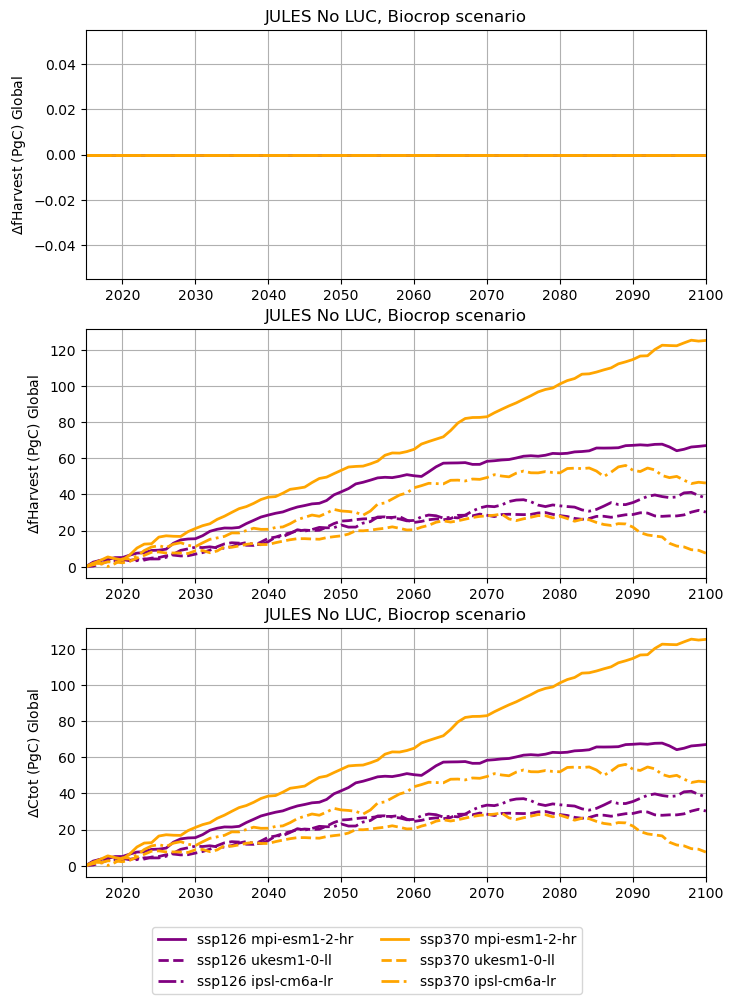

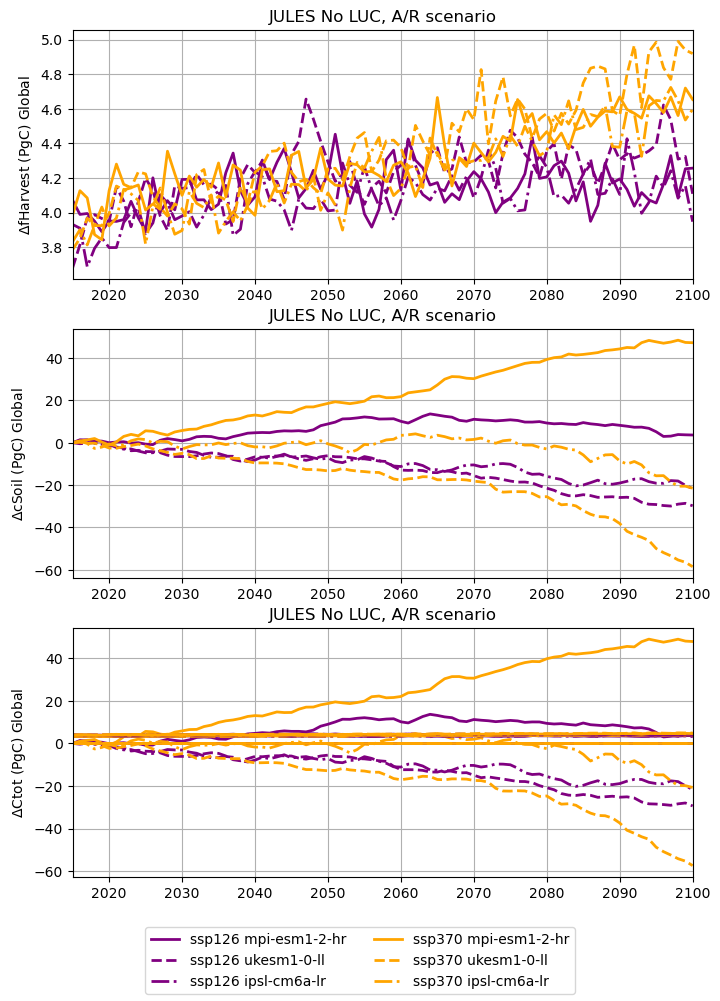

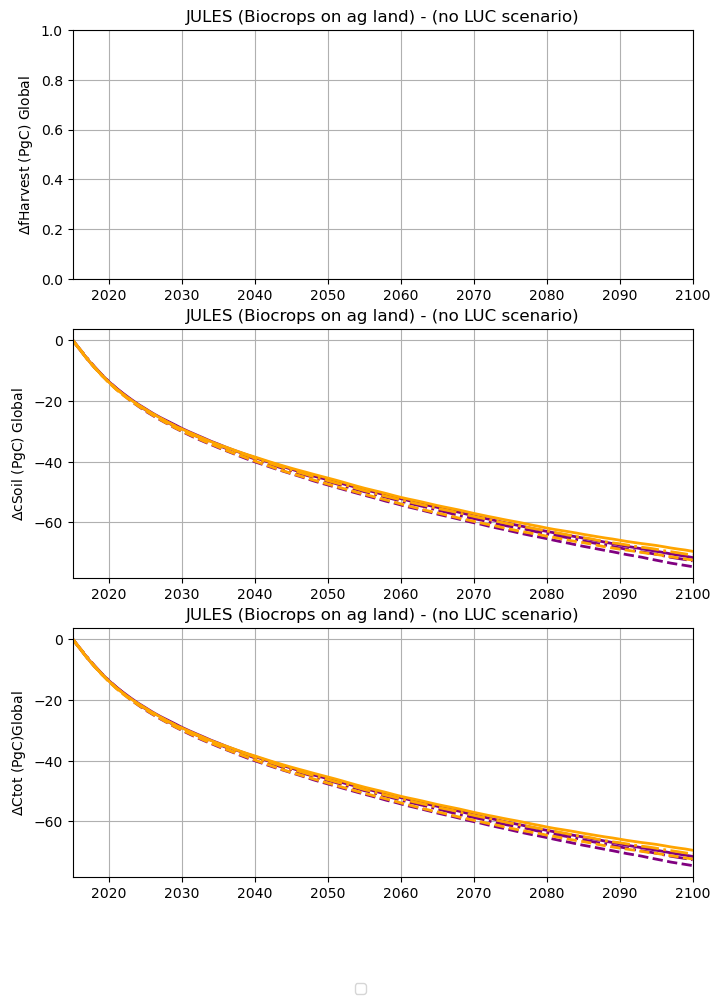

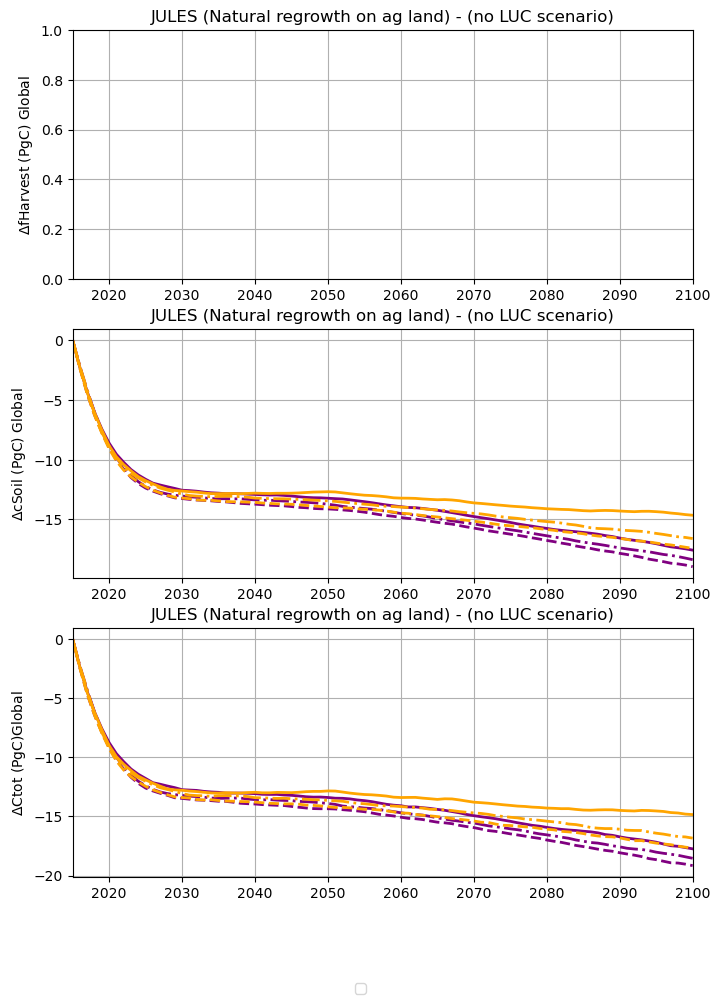

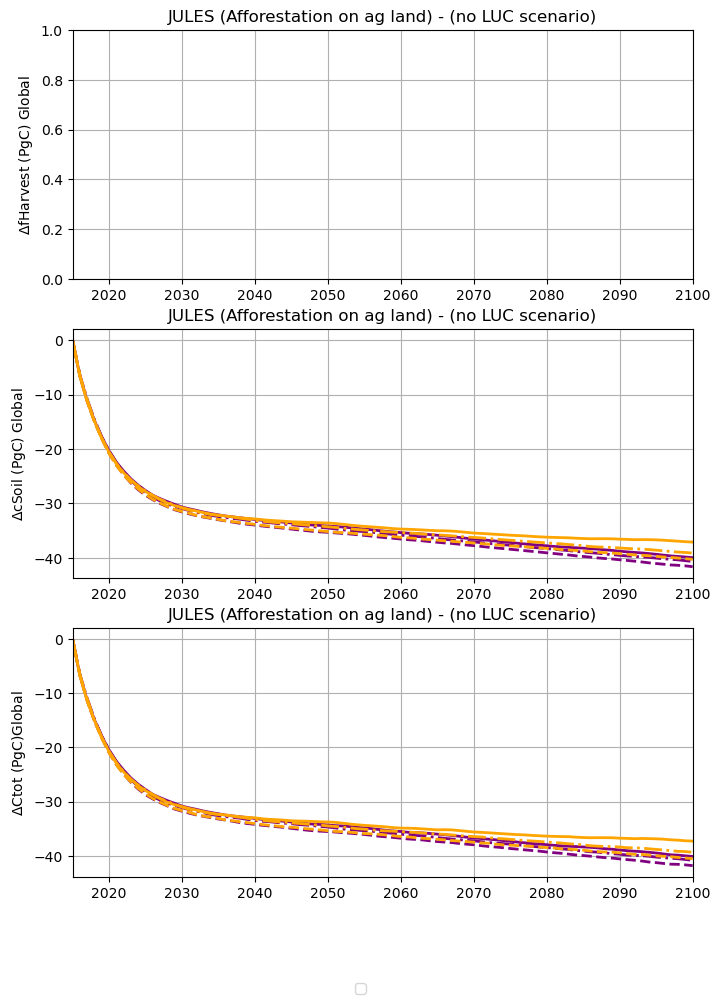

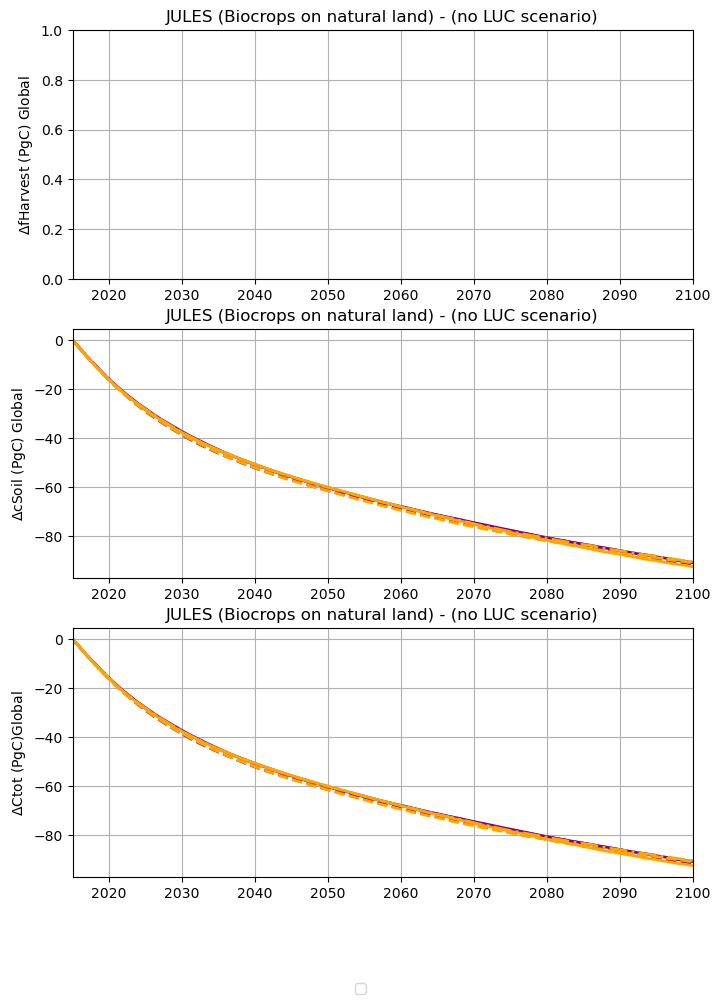

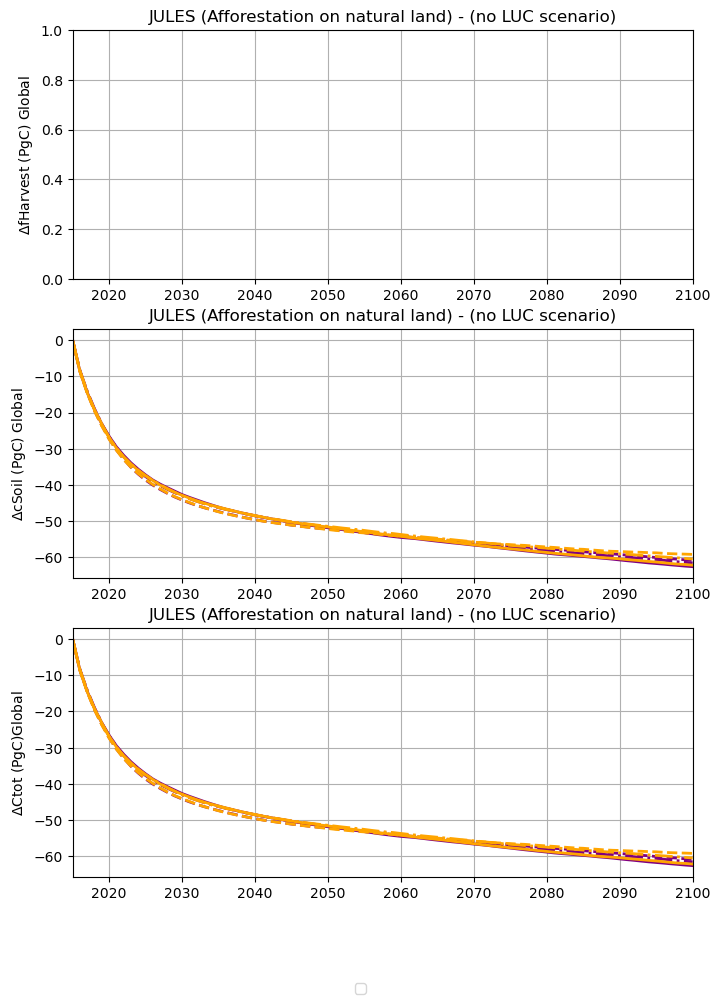

In [96]:
if __name__ == "__main__":
    jules_cpool()

    